# Exercise Notebook for the course: Learn PyTorch. Become a Deep Learning Engineer. Get Hired. - Chapter 10 "Replicating a paper"

## 0. Importing the data

In [1]:
from scripts import dataset_setup
from scripts import utilities
from scripts import model_setup
import torch
from torch import nn
import torchvision
from torchvision.datasets import DatasetFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2, InterpolationMode
import os
import pathlib
import matplotlib.pyplot as plt
from time import time
import numpy as np


### Here we define the folders structure to work with

In [2]:
MODEL_FOLDER = pathlib.Path(os.getcwd() + '/saved_models/new_model')
LOG_FOLDER = MODEL_FOLDER
FOOD101_PATH = pathlib.Path(os.getcwd() + '/Datasets/food-101') #folder where the original dataset is stored in the
DATASET_TRAIN_FOLDER = pathlib.Path(os.getcwd() + '/Datasets/train')
DATASET_TEST_FOLDER = pathlib.Path(os.getcwd() + '/Datasets/test')

In [3]:
logger = utilities.Logging_Agent(LOG_FOLDER) #a logging agent defined to keep track of the activities performed in a specific log file

In [4]:
train_test_foods = dataset_setup.dataset_creation(
    food101_folder=FOOD101_PATH,
    dataset_train_folder=DATASET_TRAIN_FOLDER,
    dataset_test_folder=DATASET_TEST_FOLDER,
#    picked_foods=['pizza', 'steak', 'sushi', 'cup_cakes', 'french_fries'],
    logger=logger,
    nr_classes=5
    )

The folders already exist: 
	/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/07_PyTorch_PaperReplicating/Datasets/train
	/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/07_PyTorch_PaperReplicating/Datasets/test
	Foods in the train and test folders: 
		['filet_mignon', 'falafel', 'beef_tartare', 'miso_soup', 'prime_rib']


## 1. Dataset and DataLoader creation

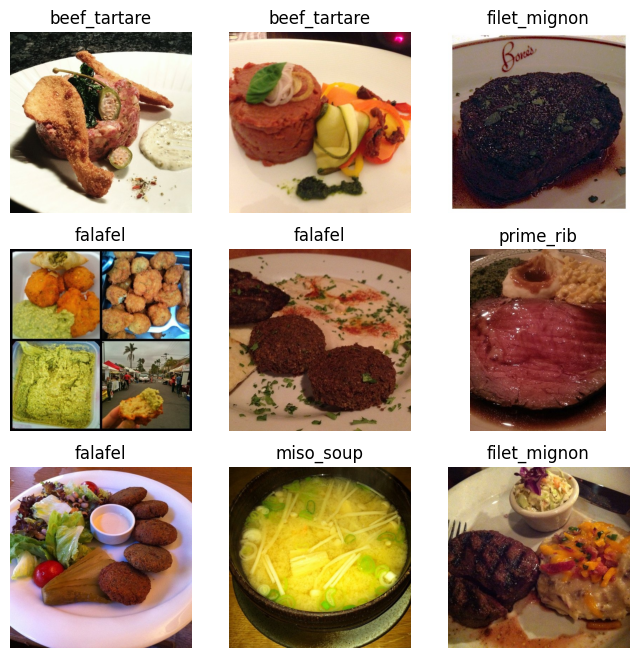

In [5]:
#visualizing a small batch of pictures just imported in the folder structure here above

utilities.plot_samples(
    path=DATASET_TRAIN_FOLDER,
    classes_names=train_test_foods
)

### A transform sequence is being set to import the picture just downloaded into a DataSet and finally into a DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


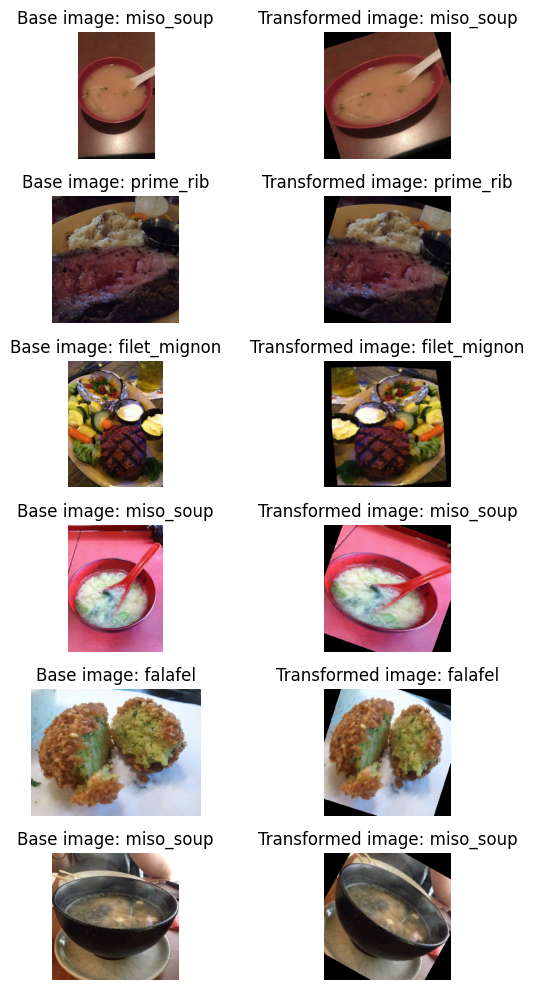

In [6]:
RESIZE = (224, 224)

transform = nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(RESIZE),
    v2.RandomHorizontalFlip(p=0.25),
    v2.RandomVerticalFlip(p=0.25),
    v2.RandomRotation(degrees=30),
    v2.RandomPerspective(p=0.25, distortion_scale=0.2),
)

transform_test = nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(RESIZE),
)

utilities.plot_samples_transformed(
    path=DATASET_TRAIN_FOLDER,
    transform=transform,
    classes_names=train_test_foods,
)


In [7]:
#Creating the DataSets from the folders created

train_dataset = ImageFolder(
    root=DATASET_TRAIN_FOLDER,
    transform=transform,
)

test_dataset = ImageFolder(
    root=DATASET_TEST_FOLDER,
    transform=transform_test,
)

In [8]:
train_dataset,test_dataset #visualizing the objects created

(Dataset ImageFolder
     Number of datapoints: 4000
     Root location: /Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/07_PyTorch_PaperReplicating/Datasets/train
     StandardTransform
 Transform: Sequential(
              (0): ToImage()
              (1): ToDtype(scale=True)
              (2): Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
              (3): RandomHorizontalFlip(p=0.25)
              (4): RandomVerticalFlip(p=0.25)
              (5): RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
              (6): RandomPerspective(p=0.25, distortion_scale=0.2, interpolation=InterpolationMode.BILINEAR, fill=0)
            ),
 Dataset ImageFolder
     Number of datapoints: 1000
     Root location: /Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/07_PyTorch_PaperReplicating/Datasets/test
     StandardTransform
 Transform: Sequential(
              (0): ToImage()
              (1): To

In [9]:
train_dataset.class_to_idx #visualizing the mapped values of the train and test labels

{'beef_tartare': 0,
 'falafel': 1,
 'filet_mignon': 2,
 'miso_soup': 3,
 'prime_rib': 4}

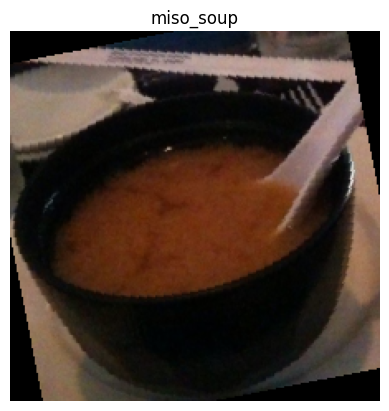

In [10]:
#visualizing a random picture picked randomly from the dataset

from random import randint

random_pic = randint(0, len(train_dataset))

img, label = train_dataset[random_pic]

plt.imshow(img.permute(1, 2, 0))
plt.title(train_dataset.classes[label])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


### Finally a DataLoader is being built from the DataSets

In [11]:
BATCH_SIZE = 2**5

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True #since the patchembedding layer is dependant from the batch size, it is crucial to have a proper batch size of 32 for every batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=os.cpu_count(),
    drop_last=True #since the patchembedding layer is dependant from the batch size, it is crucial to have a proper batch size of 32 for every batch
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

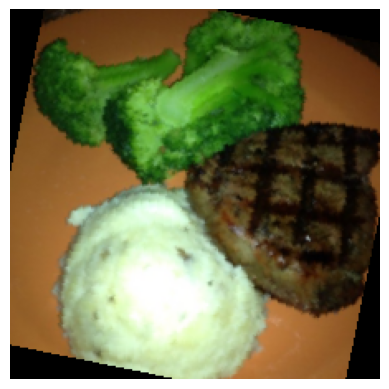

In [12]:
first_image_dataloader = next(iter(train_dataloader))[0][0]
plt.imshow(first_image_dataloader.permute(1, 2, 0))
plt.axis('off')

## 2. Neural Network architecture
### To replicate the study at this <a href='https://arxiv.org/pdf/2010.11929'>link</a>, we first have to make a quick recape of what should be done.

<img src=https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png height=450>

* ### 1. We must patchify a picture to build the embeddings for every patch
* ### 2. Flattening of the embeddings is needed
* ### 3. A Transformer encoder must be built as follow:
* ### 3a. A Layer Norm will process the linear projection of flattened Patches
* ### 3b. A MultiHead Attention layer will follow to get an output which will be added to the input of this Transformer Encoder block.
* ### 3c. Another Layer Normalization is applied
* ### 3d. A final MLP layer will close the block and we add to the output the input of the LN + MLP inner block
* ### To close the model we have then a MLP head as described in the paper (basically fully connected layer or layers depending on the case)

### Here below the equations reported in the paper

<img src='https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png' height=150>

### 2.1 Example of patchified picture

In [13]:
PATCH_SIZE = 16 #to replicate the ViT Base size the patches must be (16 x 16)
nr_patches = img.shape[2] * img.shape[1] // PATCH_SIZE ** 2

print(f'The picture resolution is: {img.shape[1]} x {img.shape[2]}\n'
      f'How many patches will the picture be split into ? {nr_patches}')

The picture resolution is: 224 x 224
How many patches will the picture be split into ? 196


([], [])

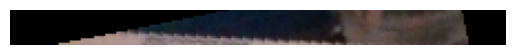

In [14]:
#Let's start patchifying just a single raw of a randomly picked picture belonging to the dataset
plt.imshow(img.permute(1, 2, 0)[:PATCH_SIZE, : , :])
plt.axis('off')
plt.xticks([])
plt.yticks([])

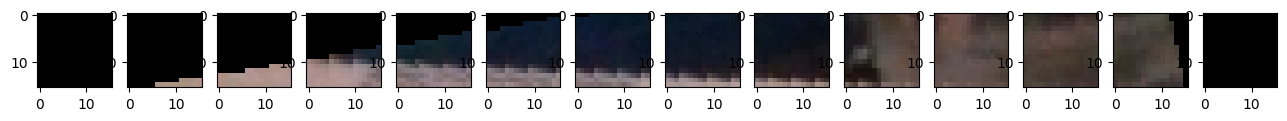

In [15]:
#Let's now patchify the whole first raw
fig = plt.figure(figsize=(PATCH_SIZE, PATCH_SIZE))
for index, patch in enumerate(range(0, img.shape[1], PATCH_SIZE)):
  ax = fig.add_subplot(1, img.shape[1] // PATCH_SIZE, index + 1)
  ax = plt.imshow(img.permute(1, 2, 0)[:PATCH_SIZE, patch:PATCH_SIZE + patch, :])


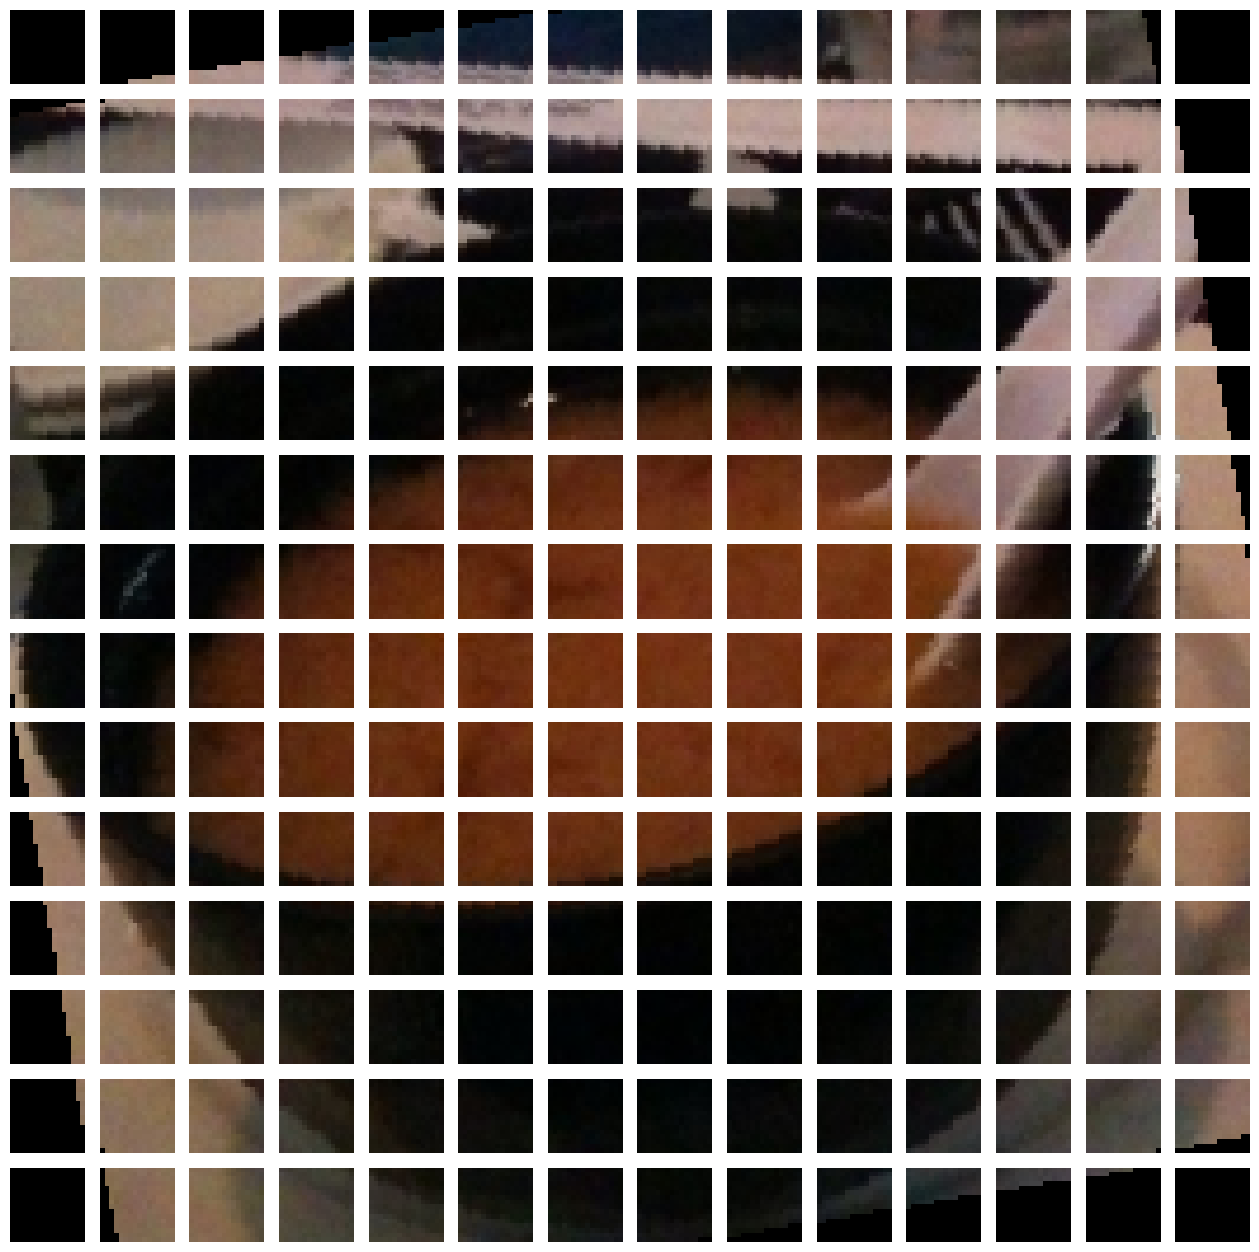

In [16]:
#Finally we patchify the whole picture
fig = plt.figure(figsize=(PATCH_SIZE, PATCH_SIZE))
for row_index, row in enumerate(range(0, img.shape[2], PATCH_SIZE)):
  for col_index, patch in enumerate(range(0, img.shape[1], PATCH_SIZE)):
    ax = fig.add_subplot(img.shape[2] // PATCH_SIZE, img.shape[1] // PATCH_SIZE, (col_index + 1) + (row_index * 14))
    ax = plt.imshow(img.permute(1, 2, 0)[row:row + PATCH_SIZE, patch:PATCH_SIZE + patch, :])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

### 2.2 Using Conv2D to create the embeddings
#### The whole process of getting the picture patchified will be performed by means of a Conv2D layer set with a stride equal to the PATCH_SIZE. This way not only we will have split the original picture in the needed patches, but we will have supplied the model with learnable embeddings.
#### This idea comes directly from the paper

In [17]:
out_channels = PATCH_SIZE ** 2 * img.shape[0] #this is coming directly from paragraph 3.1 of the paper
out_channels

768

In [18]:
conv2d_embeddings = nn.Conv2d(
    in_channels=3,
    out_channels=out_channels,
    stride=PATCH_SIZE,
    kernel_size=PATCH_SIZE,
)

embedding = conv2d_embeddings(img.unsqueeze(0))

In [19]:
embedding.shape #checking the dimensionality of the output of the conv2d layer

torch.Size([1, 768, 14, 14])

In [20]:
flatten_embeddings = nn.Flatten(start_dim=2, end_dim=3)
embedding = flatten_embeddings(embedding)
embedding.shape

torch.Size([1, 768, 196])

In [21]:
#The last thing to do now is to rearrange the vector, since the expected dimensions are (nr_batches, nr_patches, nr_embeddings)
embedding = embedding.permute(0, 2, 1)
embedding.shape

torch.Size([1, 196, 768])

### 2.3 Creating a layer for the patch embedding (equation 1)

#### As stated here under we must:
* #### create the embeddings by means a Conv2D layer and then a Flatten layer + permute operation
* #### create a Class Token prepended to the embeddings already created via the block built above. We will build a tensor with the proper dimensions (1, 768) [if we consider images of 224x224 and patch size of 16], then we concatenate that tensor to the dimension number 1 (pythonic), of the embeddings. Since that tensor must be an embedding (learnable) than we must build it as if it were a parameter of the DNN
* #### create a Position Token added to the tensor directly at the output of the previous operations

<img src=https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png height=450>

In [22]:
class PatchEmbedding(nn.Module):
    '''
    This class defines the first block of the final DNN we are replicating. 
    this first block refers to the first equation of the paper linked above and basically converts a picture in embeddings based on a given PATCH_SIZE
    '''
    def __init__(self, in_channels:int, 
                 out_channels:int,
                 patch_size:int,
                 batch_size:int,
                 img_size:tuple
                 ):
        '''
        This constructor defines the first block of the final DNN we are replicating: the embedding layer.
        :param in_channels: the number of input channels received by the 2D Convolutional layer which patchifies the picture
        :param out_channels: the number of output channels. This number is based on the info found in the paper itself in paragraph 3.1
        :param patch_size: the patch size in pixels
        :param batch_size: the batch size passed at train time
        :param img_size: the size of a single image of the dataset
        '''
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.patch_size = patch_size
        
        self.embedding_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      stride=patch_size,
                      kernel_size=patch_size),
            nn.Flatten(start_dim=2, end_dim=3),
        )
        
        self.class_embedding = nn.Parameter(
            data=torch.ones(batch_size, 1, out_channels),
            requires_grad=True
        )
        patches_quantity = img_size[0] * img_size[1] // (PATCH_SIZE ** 2)
        self.position_embedding = nn.Parameter(
            data=torch.ones(batch_size, patches_quantity + 1, out_channels),
            requires_grad=True
        )
    
    def forward(self, x):
        x = self.embedding_layer(x).permute(0, 2, 1)
        x = torch.cat([x, self.class_embedding], dim=1)
        x += self.position_embedding
        return x

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       out_channels=out_channels,
                                       patch_size=PATCH_SIZE,
                                       batch_size=BATCH_SIZE,
                                       img_size=(224, 224))
patch_embedding_layer

PatchEmbedding(
  (embedding_layer): Sequential(
    (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (1): Flatten(start_dim=2, end_dim=3)
  )
)

In [23]:
import torchinfo

torchinfo.summary(patch_embedding_layer,
                  input_size=(BATCH_SIZE, 3, 224, 224),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
PatchEmbedding                           [32, 3, 224, 224]         [32, 197, 768]            4,866,048                 True
├─Sequential: 1-1                        [32, 3, 224, 224]         [32, 768, 196]            --                        True
│    └─Conv2d: 2-1                       [32, 3, 224, 224]         [32, 768, 14, 14]         590,592                   True
│    └─Flatten: 2-2                      [32, 768, 14, 14]         [32, 768, 196]            --                        --
Total params: 5,456,640
Trainable params: 5,456,640
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 3.70
Input size (MB): 19.27
Forward/backward pass size (MB): 38.54
Params size (MB): 2.36
Estimated Total Size (MB): 60.17

In [24]:
dummy_train_batch, dummy_target_batch = next(iter(train_dataloader))
dummy_train_batch.shape, dummy_target_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [25]:
patch_embedding_layer(dummy_train_batch).shape

torch.Size([32, 197, 768])

#### We merged a stack of layers to form the first block of our DNN. Now we plot the feature map to see what it looks like.

Text(0.5, 1.0, 'Feature map - shape: (197, 768)')

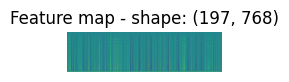

In [26]:
#detaching the tensor to convert it to a NumPy array. We detach it, beacuse we must say to the system 'hey stop tracking the grads' prior to convert it to a numpy object
feature_map = patch_embedding_layer(dummy_train_batch)[0, : ,:].detach().numpy()
plt.figure(figsize=(2, 10))
plt.imshow(feature_map)
plt.axis('off')
plt.title(f'Feature map - shape: {feature_map.shape}')

#### Finally both the block we created and the dataloader work perfectly together and all the steps to cover equation (1) are now covered.

<img src='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-equation-1-putting-it-all-together.png' height=500>



### 2.4 MultiHeadSelfAttention Layer (equation 2)

In [27]:
NUM_HEADS = 12

class MultiHeadSelfAttention(nn.Module):
    '''
    this class defines the second block of the final DNN we are replicating.
    '''
    
    def __init__(self,
                 embedding_layer:int,
                 nr_heads:int,
                 attention_dropout:int = 0,
                 ):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_layer)
        self.mha = nn.MultiheadAttention(
            embed_dim=embedding_layer,
            num_heads=nr_heads,
            dropout=attention_dropout,
            batch_first=True
        )
    
    def forward(self, x):
        x0 = x.clone()
        x = self.layer_norm(x)
        x, _ = self.mha(
            key=x, 
            value=x, 
            query=x, 
            need_weights=False
        )
        
        return x + x0
    
mha_layer = MultiHeadSelfAttention(
    embedding_layer=out_channels,
    nr_heads=NUM_HEADS,
    attention_dropout=0,
)


#### we pass the output of the embedding layer using a dummy train batch, through the new block, to chech the shape of the output consistency with what stated in the paper

In [28]:
mha_layer(patch_embedding_layer(dummy_train_batch)).shape

torch.Size([32, 197, 768])

### 2.5 MLP Layer (equation 3)

* #### The MLP refers to the standard 'nn.Linear()' layer. MLP is a general way to call it as well as Linear Layer, Dense Layer (keras), Hidden Layer etc.
* #### The MLP can have just one layer or multiple hidden layers depending on the architecture of the DNN we're building up: the paper states that two hidden layers are applied
* #### A GELU activation function must be used according to the paper (<a href='https://docs.pytorch.org/docs/stable/generated/torch.nn.GELU.html'>link</a>)

In [29]:
MLP_SIZE = 3072 #according to table 1 of the paper
DROPOUT_RATE_MLP = 0.1 #according to the paper

class MLP(nn.Module):
    '''
    This class defines the third block of the final DNN we are replicating.
    '''
    def __init__(self,
                 embedding_layer:int,
                 mlp_size:int,
                 dropout:float,
                 ):
        
        super().__init__()
        
        #create the LayerNorm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_layer)
        
        #create a sequential block of linear layers and non linear activation functions
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_layer,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_layer),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return x + self.mlp(self.layer_norm(x))

mlp_layer = MLP(
    embedding_layer=out_channels,
    mlp_size=MLP_SIZE,
    dropout=DROPOUT_RATE_MLP,
)

mlp_layer

MLP(
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.1, inplace=False)
  )
)

In [30]:
torch.manual_seed(46)
mlp_layer(mha_layer(patch_embedding_layer(dummy_train_batch)))

tensor([[[ 1.2871,  0.9950,  1.3692,  ...,  0.9503,  0.2826,  1.0765],
         [ 1.2223,  0.8715,  1.3767,  ...,  0.8832,  0.3071,  1.0644],
         [ 1.2074,  0.9153,  1.3599,  ...,  0.9105,  0.3007,  1.0978],
         ...,
         [ 1.1051,  1.0279,  1.4499,  ...,  0.9582,  0.3336,  1.0773],
         [ 1.2636,  0.9045,  1.2755,  ...,  0.8626,  0.3675,  1.0355],
         [ 2.3222,  1.8369,  2.4106,  ...,  1.8982,  1.2516,  2.1430]],

        [[ 1.2543,  0.9664,  1.4867,  ...,  0.6649,  0.2535,  1.2852],
         [ 1.3516,  1.1659,  1.4673,  ...,  0.7909,  0.2479,  1.2274],
         [ 1.3307,  1.0765,  1.3728,  ...,  0.9914,  0.2153,  1.3399],
         ...,
         [ 1.3355,  1.1316,  1.4503,  ...,  0.7887,  0.3429,  1.3020],
         [ 1.6094,  1.1084,  1.4164,  ...,  0.9635,  0.3670,  1.1956],
         [ 2.3237,  1.9808,  2.5312,  ...,  1.8148,  1.3020,  2.1496]],

        [[ 1.2717,  0.9142,  1.5345,  ...,  0.9509,  0.3983,  1.0812],
         [ 1.2563,  0.8996,  1.4602,  ...,  0

### 2.6 Putting up the TransformerEncoder (equation 2 + equation 3)

In [31]:
class TransformerBlock(nn.Module):
    '''
    this class puts up together the MSA and MLP blocks.
    '''
    def __init__(self,
                 embedding_layer:int,
                 nr_heads:int,
                 mlp_size:int,
                 dropout:float = 0,
                 attention_dropout:int = 0,
                 ):
        super().__init__()
        
        self.msa = MultiHeadSelfAttention(
            embedding_layer=embedding_layer,
            nr_heads=nr_heads,
            attention_dropout=attention_dropout,
        )
        self.mlp = MLP(
            embedding_layer=embedding_layer,
            mlp_size=mlp_size,
            dropout=dropout,
        )
    
    def forward(self, x):
        return self.mlp(self.msa(x))

transformer_block = TransformerBlock(
    embedding_layer=out_channels,
    nr_heads=NUM_HEADS,
    mlp_size=MLP_SIZE,
    dropout=DROPOUT_RATE_MLP,
    attention_dropout=0,
)

transformer_block

TransformerBlock(
  (msa): MultiHeadSelfAttention(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mha): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
  )
  (mlp): MLP(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=3072, out_features=768, bias=True)
      (4): GELU(approximate='none')
      (5): Dropout(p=0.1, inplace=False)
    )
  )
)

In [32]:
torch.manual_seed(46)
transformer_block(patch_embedding_layer(dummy_train_batch)).shape

torch.Size([32, 197, 768])

#### Let's check whether the architecture is the one we expect with a torchinfo.summary

In [33]:
torchinfo.summary(
    model=transformer_block,
    input_size=(32, 197, 768),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    row_settings=['var_names']
)

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
TransformerBlock (TransformerBlock)      [32, 197, 768]            [32, 197, 768]            --                        True
├─MultiHeadSelfAttention (msa)           [32, 197, 768]            [32, 197, 768]            --                        True
│    └─LayerNorm (layer_norm)            [32, 197, 768]            [32, 197, 768]            1,536                     True
│    └─MultiheadAttention (mha)          --                        [32, 197, 768]            2,362,368                 True
├─MLP (mlp)                              [32, 197, 768]            [32, 197, 768]            --                        True
│    └─LayerNorm (layer_norm)            [32, 197, 768]            [32, 197, 768]            1,536                     True
│    └─Sequential (mlp)                  [32, 197, 768]            [32, 197, 768]            --                        True
│  

#### We just coded the decoder encoder block as reported here under, where the author of the course mapped the equations ot the code snippet:

<img src='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-transformer-encoder-mapped-to-code.png' height=750>

In [34]:
NR_CLASSES = len(train_dataset.classes)
IMG_SIZE = (224, 224)
TRANSFORMER_ENCODER_LAYERS = 12

NR_CLASSES, IMG_SIZE, out_channels, TRANSFORMER_ENCODER_LAYERS

(5, (224, 224), 768, 12)

In [35]:
from scripts.model_setup import Model_Blueprint
class ViT(Model_Blueprint):
    '''
    Final class to build up a ViT-based model.
    '''
    def __init__(self,
                 name,
                 starting_input_channels:int,
                 embedding_output_channels:int,
                 patch_size:int,
                 batch_size:int,
                 img_size:tuple,
                 transformer_encoder_layers:int,
                 nr_heads:int,
                 mlp_size:int,
                 mlp_dropout:float,
                 attention_dropout:float,
                 final_output_length:int):
        
        super().__init__(name=name)
        
        self.patch_embedding = PatchEmbedding(
            in_channels=starting_input_channels,
            out_channels=embedding_output_channels,
            patch_size=patch_size,
            batch_size=batch_size,
            img_size=img_size
        )
        
        self.transformer_encoder_layers = transformer_encoder_layers
        self.transformer_block = nn.Sequential(*[TransformerBlock(
            embedding_layer=embedding_output_channels,
            nr_heads=nr_heads,
            mlp_size=mlp_size,
            dropout=mlp_dropout,
            attention_dropout=attention_dropout) for _ in range(transformer_encoder_layers)]
        )
    
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_output_channels),
            nn.Linear(
            in_features=embedding_output_channels, #only the classification token is passed through the final layer. All of the other embeddings won't be passed
            out_features=final_output_length)
        )
    
    def define_architecture(self):
        pass
        
    def forward(self, x):
        x=self.patch_embedding(x)
        x=self.transformer_block(x)
        x=self.mlp_head(x[:, 0])
        return x
    
vit_model = ViT(
    name='ViT_model',
    starting_input_channels=3,
    embedding_output_channels=out_channels,
    patch_size=PATCH_SIZE,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    transformer_encoder_layers=TRANSFORMER_ENCODER_LAYERS,
    nr_heads=NUM_HEADS,
    mlp_size=MLP_SIZE,
    mlp_dropout=DROPOUT_RATE_MLP,
    attention_dropout=0,
    final_output_length=NR_CLASSES)

torchinfo.summary(
    model=vit_model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
)    

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
ViT                                           [32, 3, 224, 224]         [32, 5]                   --                        True
├─PatchEmbedding: 1-1                         [32, 3, 224, 224]         [32, 197, 768]            4,866,048                 True
│    └─Sequential: 2-1                        [32, 3, 224, 224]         [32, 768, 196]            --                        True
│    │    └─Conv2d: 3-1                       [32, 3, 224, 224]         [32, 768, 14, 14]         590,592                   True
│    │    └─Flatten: 3-2                      [32, 768, 14, 14]         [32, 768, 196]            --                        --
├─Sequential: 1-2                             [32, 197, 768]            [32, 197, 768]            --                        True
│    └─TransformerBlock: 2-2                  [32, 197, 768]            [32, 197, 768]        


#### testing the ViT model built, with the legit train_dataloader

In [36]:
vit_model(dummy_train_batch).shape

torch.Size([32, 5])

### the shape of the output is what we expect. The model should be properly built.

## 3. Training the model

In [37]:
LEARNING_RATE = 5e-3
MAX_EPOCHS = 2

In [38]:
device = 'mps' if torch.mps.is_available() else 'cpu'
vit_model.to(device)
print(f'The model has been passed to the {device}')

The model has been passed to the mps


In [39]:
#defining a loss criterion and an optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vit_model.parameters(), lr=LEARNING_RATE)

In [40]:
from tqdm.auto import tqdm
for epoch in range(MAX_EPOCHS):
    print(f'{' EPOCH ' + str(epoch) + ' out of ' + str(MAX_EPOCHS) + ' ':*^50}')
    epoch_loss = []
    epoch_acc = []
    epoch_train_time_start = time()
    for batch_index,(train_batch, target_batch) in enumerate(tqdm(train_dataloader)):
        #passing the batches to the proper device
        train_batch, target_batch = train_batch.to(device), target_batch.to(device)
        
        batch_train_time_start = time()
        batch_train_loss, batch_train_acc = vit_model.train_step(
            batch_X=train_batch,
            batch_y=target_batch,
            optimizer=optimizer,
            loss_foo=loss_fn,
            device=device
        )
        batch_train_time_end = time()

        #updating the lists keeping track of the losses for the batch
        epoch_loss.append(batch_train_loss)
        epoch_acc.append(batch_train_acc)

        if batch_index % 100 == 0:
            print(vit_model.write_minibatch_results_class(
                batch_index=batch_index,
                batch_quantity=len(train_dataloader),
                train_loss=epoch_loss,
                batch_loss_train=batch_train_loss,
                train_acc=epoch_acc,
                batch_acc_train=batch_train_acc,
                start_time_iteration=batch_train_time_start,
                end_time_iteration=batch_train_time_end
            ))
            
    epoch_train_time_end = time()
    print('\tEpoch training closed... Start evaluating the CV set...')
    epoch_cv_loss = []
    epoch_cv_acc = []
    for cv_train_batch, cv_target_batch in test_dataloader:
        #passing the batches to the proper device
        cv_train_batch, cv_target_batch = cv_train_batch.to(device), cv_target_batch.to(device)
        
        vit_model.eval()
        batch_cv_loss, batch_cv_acc = vit_model.eval_step(
            batch_test_X=cv_train_batch,
            batch_test_y=cv_target_batch,
            loss_foo=loss_fn,
            device=device
        )
        vit_model.train()
        
        epoch_cv_loss.append(batch_cv_loss)
        epoch_cv_acc.append(batch_cv_acc)
    
    print(vit_model.write_epoch_results_class(
        curr_iteration=epoch,
        last_iteration=MAX_EPOCHS,
        train_loss=epoch_loss,
        train_acc=epoch_acc,
        cv_loss=epoch_cv_loss,
        cv_acc=epoch_cv_acc,
        end_time_iteration=epoch_train_time_end,
        start_time_iteration= epoch_train_time_start
    ))

**************** EPOCH 0 out of 2 ****************


  0%|          | 0/125 [00:09<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    1.788 (last:    1.788) | Train Acc. epoch: 15.62% (last: 15.62%) | Elapsed Time: 3.0 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    1.814 (last:    1.675) | Train Acc. epoch: 21.10% (last: 28.12%) | Elapsed Time: 1.5 sec.
	Epoch training closed... Start evaluating the CV set...
Epoch number: 1 out of 2
	Train loss: 1.789 | Train Accuracy: 21.375%
	CV loss:    1.608 | CV Accuracy:    26.815%
	Time taken: 259.07 seconds
**************** EPOCH 1 out of 2 ****************


  0%|          | 0/125 [00:09<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    1.678 (last:    1.678) | Train Acc. epoch: 21.88% (last: 21.88%) | Elapsed Time: 2.5 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    1.657 (last:    1.981) | Train Acc. epoch: 23.48% (last: 18.75%) | Elapsed Time: 1.5 sec.
	Epoch training closed... Start evaluating the CV set...
Epoch number: 2 out of 2
	Train loss: 1.654 | Train Accuracy: 23.575%
	CV loss:    1.607 | CV Accuracy:    23.992%
	Time taken: 262.30 seconds


### Training this model for sure won't bring us anywhere since the model parameters number outscales the number of pictures we're performing the training on. To achieve the results of the paper, we'd need millions of pictures, while we're working with not more than 100k pictures (if we were dealing with the whole Food101 dataset).   It can come in handy to leverage the power of transfer learning.

## 4. Transfer Learning

### Importing the model from torchvision.models. We will use the specific class built in the model_setup script from the scripts folder. This way the pretrained model will be subclassed from the ModelBlueprint and it will be initialized with all the support functions we deisgned
### <a href='https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.ViT_B_16_Weights'>PyTorch ViT-B-16 pretrained model</a>

In [41]:
vit_model_pretrained = model_setup.ViT_B_16(name='ViT_model_pretrained')

In [42]:
import torchinfo

BATCH_SIZE = 2 ** 5
torchinfo.summary(model=vit_model_pretrained,
                  input_size=(BATCH_SIZE, 3, 224, 224),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
ViT_B_16                                           [32, 3, 224, 224]         [32, 1000]                --                        True
├─VisionTransformer: 1-1                           [32, 3, 224, 224]         [32, 1000]                768                       True
│    └─Conv2d: 2-1                                 [32, 3, 224, 224]         [32, 768, 14, 14]         590,592                   True
│    └─Encoder: 2-2                                [32, 197, 768]            [32, 197, 768]            151,296                   True
│    │    └─Dropout: 3-1                           [32, 197, 768]            [32, 197, 768]            --                        --
│    │    └─Sequential: 3-2                        [32, 197, 768]            [32, 197, 768]            85,054,464                True
│    │    └─LayerNorm: 3-3                         [32, 197

In [43]:
for param in vit_model_pretrained.parameters():
    param.requires_grad = False

In [44]:
torchinfo.summary(model=vit_model_pretrained,
                  input_size=(BATCH_SIZE, 3, 224, 224),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'],
                  row_settings=['var_names'])

Layer (type (var_name))                                           Input Shape               Output Shape              Param #                   Trainable
ViT_B_16 (ViT_B_16)                                               [32, 3, 224, 224]         [32, 1000]                --                        False
├─VisionTransformer (pre_trained_model)                           [32, 3, 224, 224]         [32, 1000]                768                       False
│    └─Conv2d (conv_proj)                                         [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
│    └─Encoder (encoder)                                          [32, 197, 768]            [32, 197, 768]            151,296                   False
│    │    └─Dropout (dropout)                                     [32, 197, 768]            [32, 197, 768]            --                        --
│    │    └─Sequential (layers)                                   [32, 197, 768]            [32, 19

### 4.a Head overwrite

In [45]:
#before overwriting the head, the pretrained model shows the following final block
vit_model_pretrained.pre_trained_model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [46]:
vit_model_pretrained.pre_trained_model.heads = nn.Linear(
    in_features=768,
    out_features=5,
    bias=True
)

vit_model_pretrained.pre_trained_model.heads

Linear(in_features=768, out_features=5, bias=True)

In [47]:
torchinfo.summary(model=vit_model_pretrained,
                  input_size=(BATCH_SIZE, 3, 224, 224),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
ViT_B_16                                           [32, 3, 224, 224]         [32, 5]                   --                        Partial
├─VisionTransformer: 1-1                           [32, 3, 224, 224]         [32, 5]                   768                       Partial
│    └─Conv2d: 2-1                                 [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
│    └─Encoder: 2-2                                [32, 197, 768]            [32, 197, 768]            151,296                   False
│    │    └─Dropout: 3-1                           [32, 197, 768]            [32, 197, 768]            --                        --
│    │    └─Sequential: 3-2                        [32, 197, 768]            [32, 197, 768]            (85,054,464)              False
│    │    └─LayerNorm: 3-3                        

### 4.b Specific definition of a dataset and dataloader to comply with the transformers used back at training time.

#### The inference transforms are available at ViT_B_16_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].



In [48]:
PRETRAIN_RESIZE = (256, 256)

pretrain_transforms = nn.Sequential(
    v2.ToImage(),
    v2.Resize(PRETRAIN_RESIZE, interpolation=InterpolationMode.BILINEAR),
    v2.CenterCrop(size=224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
)

In [49]:
pretrain_dataset_train = ImageFolder(
    root=DATASET_TRAIN_FOLDER,
    transform=pretrain_transforms
)

pretrain_dataset_cv = ImageFolder(
    root=DATASET_TEST_FOLDER,
    transform=pretrain_transforms
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].


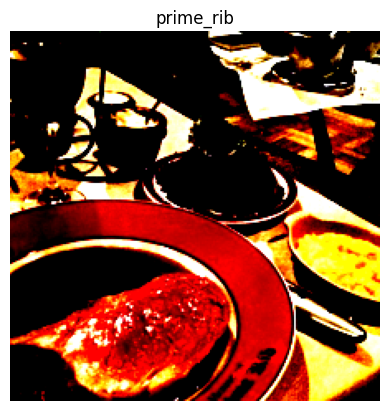

In [50]:
#visualizing a random picture picked randomly from the dataset

from random import randint

random_pic = randint(0, len(pretrain_dataset_train))

img, label = pretrain_dataset_train[random_pic]

plt.imshow(img.permute(1, 2, 0))
plt.title(pretrain_dataset_train.classes[label])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


In [51]:
pretrain_dataloader_train = DataLoader(pretrain_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
pretrain_dataloader_cv = DataLoader(pretrain_dataset_cv, batch_size=BATCH_SIZE, shuffle=True)

### 4.c Pretrained ViT-B-16 training on new dataset

In [52]:
device = 'mps' if torch.mps.is_available() else 'cpu'

In [53]:
vit_model_pretrained.to(device)
print(f'The pretrained model is now on the following device: {device}')

The pretrained model is now on the following device: mps


In [54]:
#defining a loss criterion and an optimizer
LEARNING_RATE=9e-3
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vit_model_pretrained.parameters(), lr=LEARNING_RATE)

In [55]:
MAX_EPOCHS=20

from tqdm.auto import tqdm
for epoch in range(MAX_EPOCHS):
    print(f'{' EPOCH ' + str(epoch) + ' out of ' + str(MAX_EPOCHS) :*^50}')
    epoch_loss = []
    epoch_acc = []
    epoch_train_time_start = time()
    for batch_index,(train_batch, target_batch) in enumerate(tqdm(pretrain_dataloader_train)):
        #passing the batches to the proper device
        train_batch, target_batch = train_batch.to(device), target_batch.to(device)

        batch_train_time_start = time()
        batch_train_loss, batch_train_acc = vit_model_pretrained.train_step(
            batch_X=train_batch,
            batch_y=target_batch,
            optimizer=optimizer,
            loss_foo=loss_fn,
            device=device
        )
        batch_train_time_end = time()

        #updating the lists keeping track of the losses for the batch
        epoch_loss.append(batch_train_loss)
        epoch_acc.append(batch_train_acc)

        if batch_index % 20 == 0:
            print(vit_model_pretrained.write_minibatch_results_class(
                batch_index=batch_index,
                batch_quantity=len(pretrain_dataloader_train),
                train_loss=epoch_loss,
                batch_loss_train=batch_train_loss,
                train_acc=epoch_acc,
                batch_acc_train=batch_train_acc,
                start_time_iteration=batch_train_time_start,
                end_time_iteration=batch_train_time_end
            ))

    epoch_train_time_end = time()
    print('\tEpoch training closed... Start evaluating the CV set...')
    epoch_cv_loss = []
    epoch_cv_acc = []
    for cv_train_batch, cv_target_batch in pretrain_dataloader_cv:
        #passing the batches to the proper device
        cv_train_batch, cv_target_batch = cv_train_batch.to(device), cv_target_batch.to(device)

        batch_cv_loss, batch_cv_acc = vit_model_pretrained.eval_step(
            batch_test_X=cv_train_batch,
            batch_test_y=cv_target_batch,
            loss_foo=loss_fn,
            device=device
        )

        epoch_cv_loss.append(batch_cv_loss)
        epoch_cv_acc.append(batch_cv_acc)

    #keep track of the history of the training metrics
    vit_model_pretrained.history_update('train_loss', np.mean(epoch_loss))
    vit_model_pretrained.history_update('train_acc', np.mean(epoch_acc))
    vit_model_pretrained.history_update('cv_loss', np.mean(epoch_cv_loss))
    vit_model_pretrained.history_update('cv_acc', np.mean(epoch_cv_acc))

    print(vit_model_pretrained.write_epoch_results_class(
        curr_iteration=epoch,
        last_iteration=MAX_EPOCHS,
        train_loss=epoch_loss,
        train_acc=epoch_acc,
        cv_loss=epoch_cv_loss,
        cv_acc=epoch_cv_acc,
        end_time_iteration=epoch_train_time_end,
        start_time_iteration= epoch_train_time_start
    ))

**************** EPOCH 0 out of 20****************


  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    1.483 (last:    1.483) | Train Acc. epoch: 46.88% (last: 46.88%) | Elapsed Time: 0.7 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    1.184 (last:    0.978) | Train Acc. epoch: 58.48% (last: 68.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    1.044 (last:    0.744) | Train Acc. epoch: 65.62% (last: 75.00%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.932 (last:    0.557) | Train Acc. epoch: 70.34% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.860 (last:    0.670) | Train Acc. epoch: 73.30% (last: 81.25%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.814 (last:    0.495) | Train Acc. epoch: 74.47% (last: 84.38%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.713 (last:    0.713) | Train Acc. epoch: 84.38% (last: 84.38%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.515 (last:    0.477) | Train Acc. epoch: 84.82% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.513 (last:    0.514) | Train Acc. epoch: 83.99% (last: 81.25%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.503 (last:    0.296) | Train Acc. epoch: 84.38% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.492 (last:    0.440) | Train Acc. epoch: 84.72% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.493 (last:    0.634) | Train Acc. epoch: 84.50% (last: 68.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.507 (last:    0.507) | Train Acc. epoch: 78.12% (last: 78.12%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.394 (last:    0.251) | Train Acc. epoch: 87.35% (last: 93.75%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.406 (last:    0.689) | Train Acc. epoch: 86.81% (last: 71.88%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.412 (last:    0.359) | Train Acc. epoch: 86.42% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.406 (last:    0.368) | Train Acc. epoch: 86.65% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.417 (last:    0.402) | Train Acc. epoch: 86.39% (last: 84.38%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.375 (last:    0.375) | Train Acc. epoch: 93.75% (last: 93.75%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.357 (last:    0.318) | Train Acc. epoch: 89.73% (last: 90.62%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.366 (last:    0.386) | Train Acc. epoch: 88.87% (last: 87.50%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.384 (last:    0.474) | Train Acc. epoch: 87.55% (last: 81.25%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.374 (last:    0.346) | Train Acc. epoch: 88.16% (last: 87.50%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.379 (last:    0.447) | Train Acc. epoch: 87.78% (last: 87.50%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.332 (last:    0.332) | Train Acc. epoch: 87.50% (last: 87.50%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.313 (last:    0.265) | Train Acc. epoch: 90.33% (last: 93.75%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.334 (last:    0.204) | Train Acc. epoch: 89.25% (last: 96.88%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.338 (last:    0.560) | Train Acc. epoch: 89.19% (last: 71.88%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.347 (last:    0.455) | Train Acc. epoch: 88.97% (last: 81.25%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.356 (last:    0.388) | Train Acc. epoch: 88.34% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.325 (last:    0.325) | Train Acc. epoch: 87.50% (last: 87.50%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.338 (last:    0.276) | Train Acc. epoch: 88.99% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.337 (last:    0.243) | Train Acc. epoch: 89.18% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.338 (last:    0.316) | Train Acc. epoch: 89.29% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.332 (last:    0.232) | Train Acc. epoch: 89.70% (last: 96.88%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.334 (last:    0.361) | Train Acc. epoch: 89.60% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.259 (last:    0.259) | Train Acc. epoch: 90.62% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.360 (last:    0.388) | Train Acc. epoch: 88.39% (last: 84.38%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.343 (last:    0.155) | Train Acc. epoch: 88.80% (last: 96.88%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.329 (last:    0.268) | Train Acc. epoch: 89.70% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.321 (last:    0.233) | Train Acc. epoch: 89.93% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.320 (last:    0.213) | Train Acc. epoch: 89.79% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.242 (last:    0.242) | Train Acc. epoch: 93.75% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.297 (last:    0.262) | Train Acc. epoch: 91.07% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.286 (last:    0.262) | Train Acc. epoch: 91.01% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.299 (last:    0.295) | Train Acc. epoch: 90.47% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.310 (last:    0.345) | Train Acc. epoch: 89.93% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.308 (last:    0.330) | Train Acc. epoch: 90.16% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.242 (last:    0.242) | Train Acc. epoch: 90.62% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.286 (last:    0.117) | Train Acc. epoch: 90.77% (last: 96.88%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.290 (last:    0.269) | Train Acc. epoch: 90.47% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.281 (last:    0.364) | Train Acc. epoch: 91.50% (last: 90.62%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.288 (last:    0.239) | Train Acc. epoch: 90.82% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.292 (last:    0.305) | Train Acc. epoch: 90.72% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.222 (last:    0.222) | Train Acc. epoch: 93.75% (last: 93.75%) | Elapsed Time: 0.5 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.280 (last:    0.215) | Train Acc. epoch: 90.03% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.275 (last:    0.284) | Train Acc. epoch: 90.93% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.281 (last:    0.306) | Train Acc. epoch: 90.88% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.283 (last:    0.465) | Train Acc. epoch: 91.01% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.283 (last:    0.341) | Train Acc. epoch: 90.97% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.243 (last:    0.243) | Train Acc. epoch: 93.75% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.291 (last:    0.251) | Train Acc. epoch: 90.33% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.279 (last:    0.205) | Train Acc. epoch: 91.31% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.281 (last:    0.322) | Train Acc. epoch: 91.14% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.284 (last:    0.343) | Train Acc. epoch: 90.78% (last: 84.38%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.278 (last:    0.383) | Train Acc. epoch: 91.24% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.478 (last:    0.478) | Train Acc. epoch: 81.25% (last: 81.25%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.263 (last:    0.185) | Train Acc. epoch: 91.37% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.268 (last:    0.270) | Train Acc. epoch: 91.46% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.272 (last:    0.302) | Train Acc. epoch: 91.34% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.269 (last:    0.177) | Train Acc. epoch: 91.59% (last: 100.00%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.267 (last:    0.518) | Train Acc. epoch: 91.58% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Trai

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.359 (last:    0.359) | Train Acc. epoch: 87.50% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.272 (last:    0.312) | Train Acc. epoch: 90.33% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.274 (last:    0.418) | Train Acc. epoch: 90.70% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.269 (last:    0.236) | Train Acc. epoch: 91.29% (last: 96.88%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.267 (last:    0.365) | Train Acc. epoch: 91.40% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.267 (last:    0.105) | Train Acc. epoch: 91.37% (last: 100.00%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Trai

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.257 (last:    0.257) | Train Acc. epoch: 93.75% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.273 (last:    0.262) | Train Acc. epoch: 91.82% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.256 (last:    0.316) | Train Acc. epoch: 91.92% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.273 (last:    0.351) | Train Acc. epoch: 91.03% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.268 (last:    0.240) | Train Acc. epoch: 91.01% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.261 (last:    0.195) | Train Acc. epoch: 91.49% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.241 (last:    0.241) | Train Acc. epoch: 96.88% (last: 96.88%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.263 (last:    0.275) | Train Acc. epoch: 91.67% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.252 (last:    0.271) | Train Acc. epoch: 92.30% (last: 81.25%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.252 (last:    0.187) | Train Acc. epoch: 92.11% (last: 96.88%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.257 (last:    0.281) | Train Acc. epoch: 91.90% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.257 (last:    0.471) | Train Acc. epoch: 91.77% (last: 78.12%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.195 (last:    0.195) | Train Acc. epoch: 93.75% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.263 (last:    0.158) | Train Acc. epoch: 93.45% (last: 96.88%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.250 (last:    0.207) | Train Acc. epoch: 92.91% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.254 (last:    0.223) | Train Acc. epoch: 92.16% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.251 (last:    0.216) | Train Acc. epoch: 92.09% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.247 (last:    0.357) | Train Acc. epoch: 92.26% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Train

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.191 (last:    0.191) | Train Acc. epoch: 93.75% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.233 (last:    0.122) | Train Acc. epoch: 93.01% (last: 100.00%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.250 (last:    0.407) | Train Acc. epoch: 92.23% (last: 84.38%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.241 (last:    0.144) | Train Acc. epoch: 92.32% (last: 100.00%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.243 (last:    0.156) | Train Acc. epoch: 92.01% (last: 96.88%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.238 (last:    0.142) | Train Acc. epoch: 92.33% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Tra

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.321 (last:    0.321) | Train Acc. epoch: 93.75% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.253 (last:    0.215) | Train Acc. epoch: 92.26% (last: 96.88%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.250 (last:    0.284) | Train Acc. epoch: 92.07% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.245 (last:    0.263) | Train Acc. epoch: 91.80% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.238 (last:    0.242) | Train Acc. epoch: 92.13% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.241 (last:    0.119) | Train Acc. epoch: 92.26% (last: 100.00%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Trai

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.159 (last:    0.159) | Train Acc. epoch: 96.88% (last: 96.88%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.201 (last:    0.196) | Train Acc. epoch: 94.05% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.216 (last:    0.174) | Train Acc. epoch: 93.14% (last: 100.00%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.219 (last:    0.285) | Train Acc. epoch: 93.03% (last: 93.75%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.223 (last:    0.270) | Train Acc. epoch: 92.90% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.232 (last:    0.285) | Train Acc. epoch: 92.61% (last: 96.88%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Trai

  0%|          | 0/125 [00:00<?, ?it/s]

Intermediate results for batch 000 out of 125: Train Loss epoch:    0.222 (last:    0.222) | Train Acc. epoch: 90.62% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 020 out of 125: Train Loss epoch:    0.248 (last:    0.247) | Train Acc. epoch: 91.82% (last: 87.50%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 040 out of 125: Train Loss epoch:    0.229 (last:    0.085) | Train Acc. epoch: 92.15% (last: 96.88%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 060 out of 125: Train Loss epoch:    0.229 (last:    0.132) | Train Acc. epoch: 92.42% (last: 100.00%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 080 out of 125: Train Loss epoch:    0.226 (last:    0.202) | Train Acc. epoch: 92.75% (last: 96.88%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.228 (last:    0.323) | Train Acc. epoch: 92.82% (last: 90.62%) | Elapsed Time: 0.4 sec.
Intermediate results for batch 120 out of 125: Trai

In [56]:
#saving the model leveraging the script imported via the utilities module
utilities.save_model(
    path=MODEL_FOLDER,
    model=vit_model_pretrained,
    optimizer=optimizer,
    epoch_nr=MAX_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    nr_classes=len(pretrain_dataset_train.class_to_idx)
)

Model metrics history saved in :
	/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/07_PyTorch_PaperReplicating/saved_models/new_model


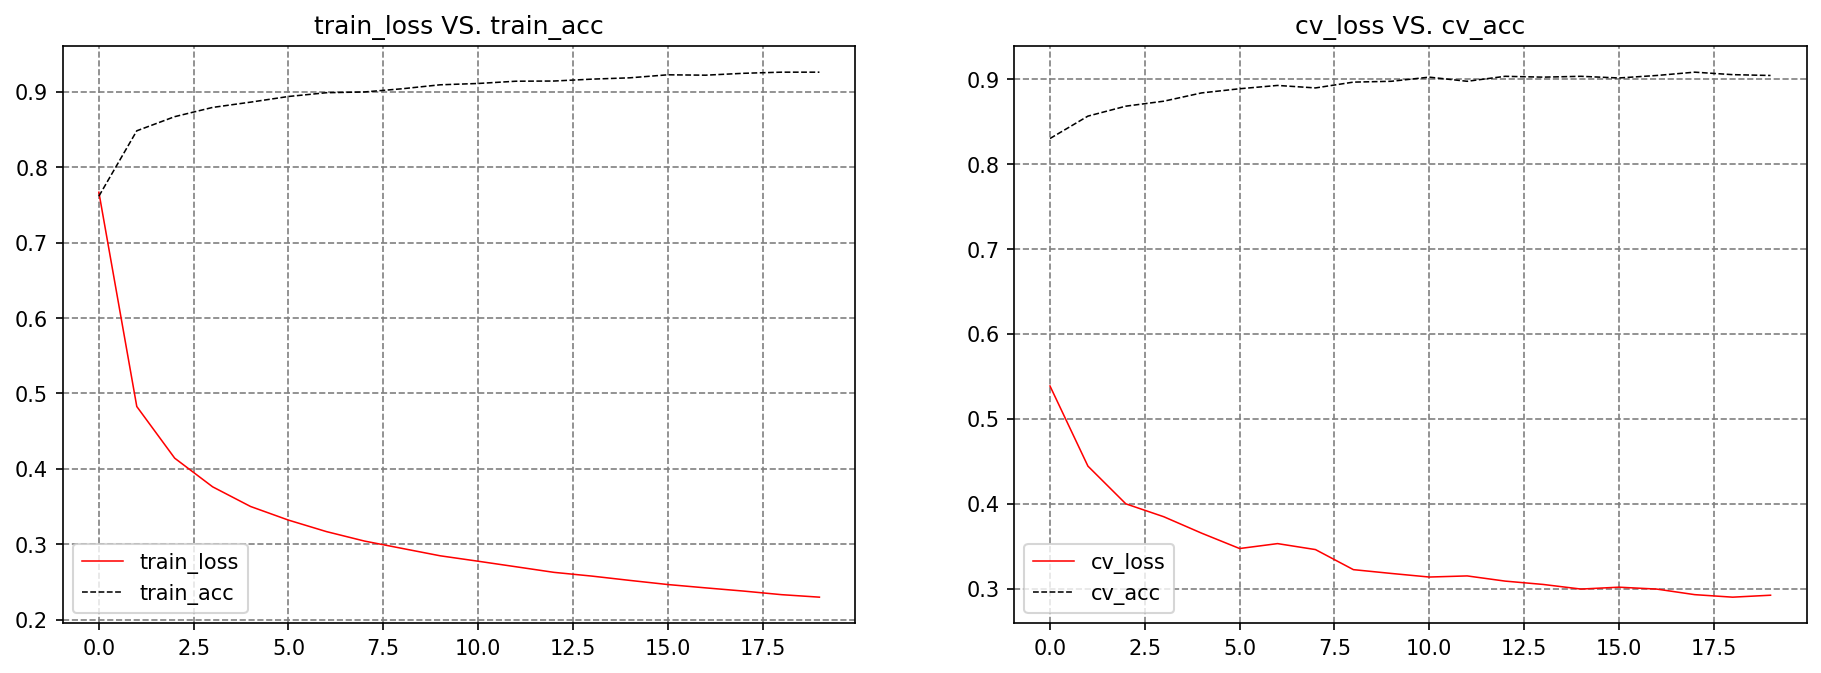

In [57]:
import matplotlib.pyplot as plt

metrics = [('train_loss', 'train_acc'),
           ('cv_loss', 'cv_acc')]

fig = plt.figure(figsize=[15, 5], dpi=150)
for index, (loss, acc) in enumerate(metrics):
    fig.add_subplot(1, 2, index + 1)
    plt.plot(
        np.arange(len(vit_model_pretrained.history[loss])),
        vit_model_pretrained.history[loss],
        label=loss,
        color='red',
        linewidth = 0.75,
    )
    plt.plot(
        np.arange(len(vit_model_pretrained.history[loss])),
        vit_model_pretrained.history[acc],
        label = acc,
        color='black',
        linewidth = 0.75,
        linestyle='--'
    )
    plt.legend()
    plt.title(f'{loss } VS. {acc}')


    plt.grid(linestyle='--', color='gray')

plt.savefig(MODEL_FOLDER / 'loss_acc_history.jpg')